<a href="https://colab.research.google.com/github/ManavMNair/Quantum_Computing_Project/blob/main/Image%20Representations/FRQI/FRQI_for_variable_sizes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Installing and importing CIRQ package for quantum simulation

In [ ]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")

installing cirq...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.8/670.8 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.5/430.5 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 72.3 MB/s eta 0:00:00
installed cirq.


##Import necessary packages

In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import drive



##File upload for encoding

In [ ]:
from google.colab import files
uploaded = files.upload()
img = next(iter(uploaded))


Saving 23901.jpg to 23901.jpg


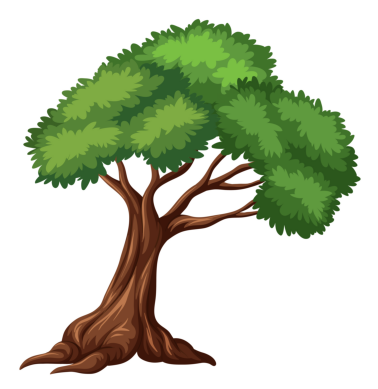

In [ ]:
# Load the input image
img = Image.open(img)
plt.imshow(img)
plt.axis("off")
plt.show()

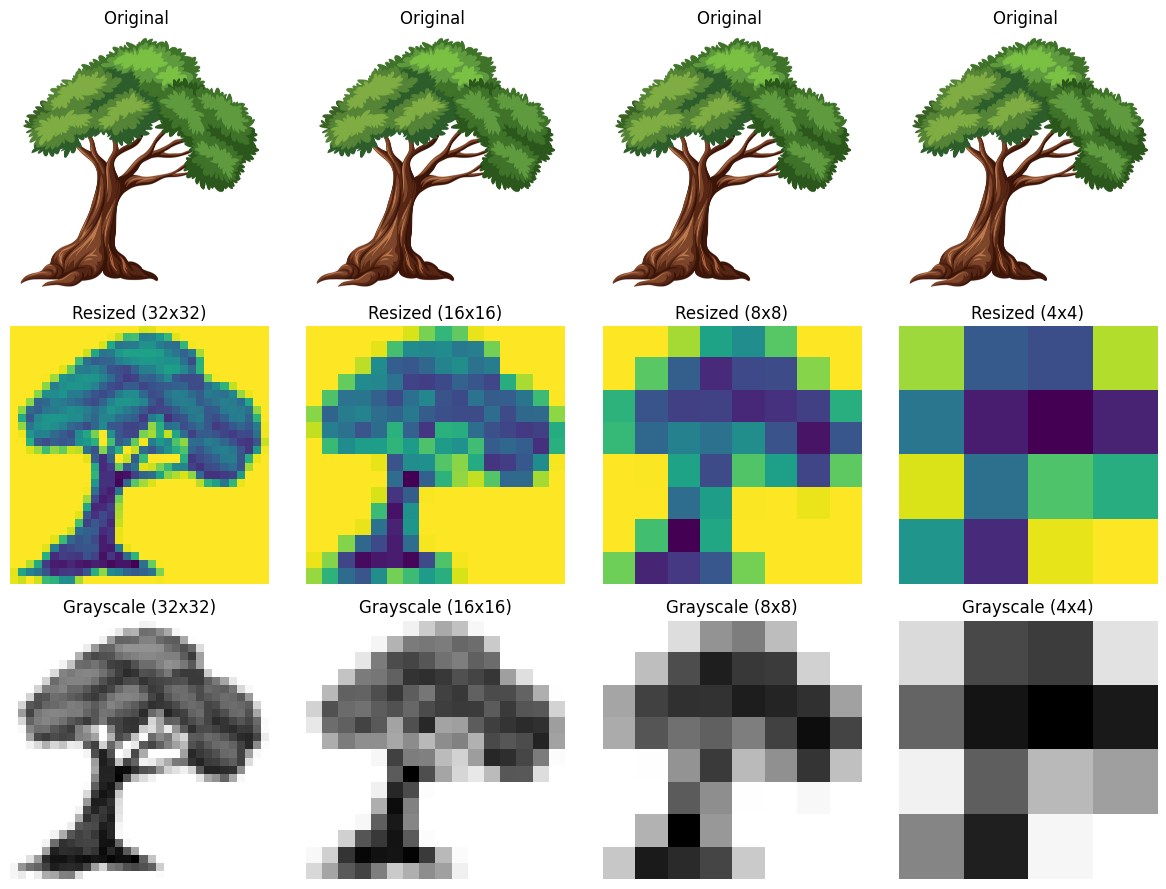

In [ ]:
sizes = [32, 16, 8, 4]
img_resized = []
img_array = []

# Resize and convert to grayscale arrays
for size in sizes:
    resized = img.resize((size, size)).convert("L")
    img_resized.append(resized)
    img_array.append(np.array(resized))

# Plot in 3 rows × 4 columns
plt.figure(figsize=(12, 9))

# Row 1: Originals
for i, size in enumerate(sizes):
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(f"Original ")
    plt.axis("off")

# Row 2: Resized
for i, size in enumerate(sizes):
    plt.subplot(3, 4, 4 + i+1)
    plt.imshow(img_resized[i])
    plt.title(f"Resized ({size}x{size})")
    plt.axis("off")

# Row 3: Grayscale
for i, size in enumerate(sizes):
    plt.subplot(3, 4, 8 + i+1)
    plt.imshow(img_array[i], cmap="gray")
    plt.title(f"Grayscale ({size}x{size})")
    plt.axis("off")

plt.tight_layout()
plt.show()





##FRQI Encoding Function

In [ ]:
def frqi_encode(image, measure=False):
    size = len(image)
    n = size.bit_length() - 1
    num_pos_qubits = 2 * n  # position qubits

    color = cirq.NamedQubit("color")
    pos = [cirq.NamedQubit(f"p{i}") for i in range(num_pos_qubits)]
    circuit = cirq.Circuit()

    pixels = [image[r][c] for r in range(size) for c in range(size)]
    theta = [(pix / 255) * (np.pi / 2) for pix in pixels]

    circuit.append(cirq.H.on_each(pos))

    for i, angle in enumerate(theta):
        if angle == 0:
            continue

        bin_str = format(i, f'0{num_pos_qubits}b')
        controls = []
        for j, bit in enumerate(bin_str):
            if bit == "0":
                circuit.append(cirq.X(pos[j]))
            controls.append(pos[j])

        circuit.append(cirq.ry(2 * angle)(color).controlled_by(*controls))

        for j, bit in enumerate(bin_str):
            if bit == "0":
                circuit.append(cirq.X(pos[j]))

    if measure:
        circuit.append(cirq.measure(color, *pos, key="result"))

    return circuit


#Image Encoding

In [ ]:
circuit = [frqi_encode(img_array[i], measure=False) for i in range(len(sizes))]

##Functions for simulations and reconstruction

In [ ]:
def frqi_simulate_measure(circuit, sim, repetitions=8192, size=16):
    """Run FRQI circuit with measurement and return histogram of results."""
    result = sim.run(circuit, repetitions=repetitions)
    histogram = result.histogram(key="result")  # counts for each bitstring
    return histogram

def frqi_reconstruct_from_hist(histogram, size=16):
    """Reconstruct image from FRQI measurement histogram."""
    num_pos_qubits = int(np.log2(size * size))
    image = np.zeros((size, size))

    for pos_index in range(size * size):
        pos_str = format(pos_index, f'0{num_pos_qubits}b')
        key0 = int("0" + pos_str, 2)  # color = 0
        key1 = int("1" + pos_str, 2)  # color = 1

        N0 = histogram.get(key0, 0)
        N1 = histogram.get(key1, 0)
        N = N0 + N1
        if N == 0:
            continue

        P1 = N1 / N
        theta = np.arcsin(np.sqrt(P1))
        intensity = 255 * (theta / (np.pi / 2))
        row, col = divmod(pos_index, size)
        image[row, col] = intensity

    return image


##Circuit Simulation

In [ ]:

sim = cirq.Simulator()
repetitions = [32768, 24576, 16384, 8192]   #We can change the shots here for [32, 16, 8, 4] corresponding images sizes
#repetitions = [400000, 400000, 400000,400000]   #We can change the shots here for [32, 16, 8, 4] corresponding images sizes
circuit_m = []
hist = []

for i in range(len(sizes)):
    # Get image size
    size_i = img_array[i].shape[0]

    # 1. Encode image into FRQI circuit with measurement
    circuit_i = frqi_encode(img_array[i], measure=True)
    circuit_m.append(circuit_i)

    # 2. Run simulation + get histogram
    hist_i = frqi_simulate_measure(circuit_i, sim, repetitions=repetitions[i], size=size_i)
    hist.append(hist_i)




##Ploting the measurements
- Only good for small image sizes, very difficult for higher image sizes since the number of bars increases the plot become complex and congested

In [ ]:
# plt.figure(figsize=(18, 6))
# plt.bar(
#     [format(k, f'0{num_pos_qubits+1}b') for k in hist.keys()],
#     hist.values()
# )
# plt.xticks(rotation=90)
# plt.xlabel("Measured bitstring (color + position)")
# plt.ylabel("Counts")
# plt.title("FRQI measurement results")
# plt.show()


##Image reconstruction

In [ ]:
# 3. Reconstruct image from histograms
reconstructed = []
for i in range(len(sizes)):
  reconstructed.append(frqi_reconstruct_from_hist(hist[i], sizes[i]))



##Evaluation

In [ ]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity


def evaluate_reconstruction(original, reconstructed):
    # Convert to float64
    original = np.array(original, dtype=np.float64)
    reconstructed = np.array(reconstructed, dtype=np.float64)

    # Clip to valid range
    original = np.clip(original, 0, 255)
    reconstructed = np.clip(reconstructed, 0, 255)

    # PSNR
    psnr_val = peak_signal_noise_ratio(original, reconstructed, data_range=255)

    # Determine appropriate win_size for SSIM
    min_dim = min(original.shape)
    win_size = min(min_dim, 7)  # default is 7
    if win_size % 2 == 0:
        win_size -= 1  # make it odd

    # SSIM
    ssim_val = structural_similarity(original, reconstructed, data_range=255, win_size=win_size)

    return psnr_val, ssim_val


# Compute PSNR and SSIM for all image sizes
psnr_vals = []
ssim_vals = []

for i in range(len(sizes)):
    psnr, ssim = evaluate_reconstruction(img_array[i], reconstructed[i])
    psnr_vals.append(psnr)
    ssim_vals.append(ssim)
    print(f"Size {sizes[i]}x{sizes[i]} -> PSNR: {psnr:.2f} dB, SSIM: {ssim:.4f}")


Size 32x32 -> PSNR: 26.87 dB, SSIM: 0.9550
Size 16x16 -> PSNR: 32.32 dB, SSIM: 0.9938
Size 8x8 -> PSNR: 35.84 dB, SSIM: 0.9975
Size 4x4 -> PSNR: 36.17 dB, SSIM: 0.9968


##Overall result

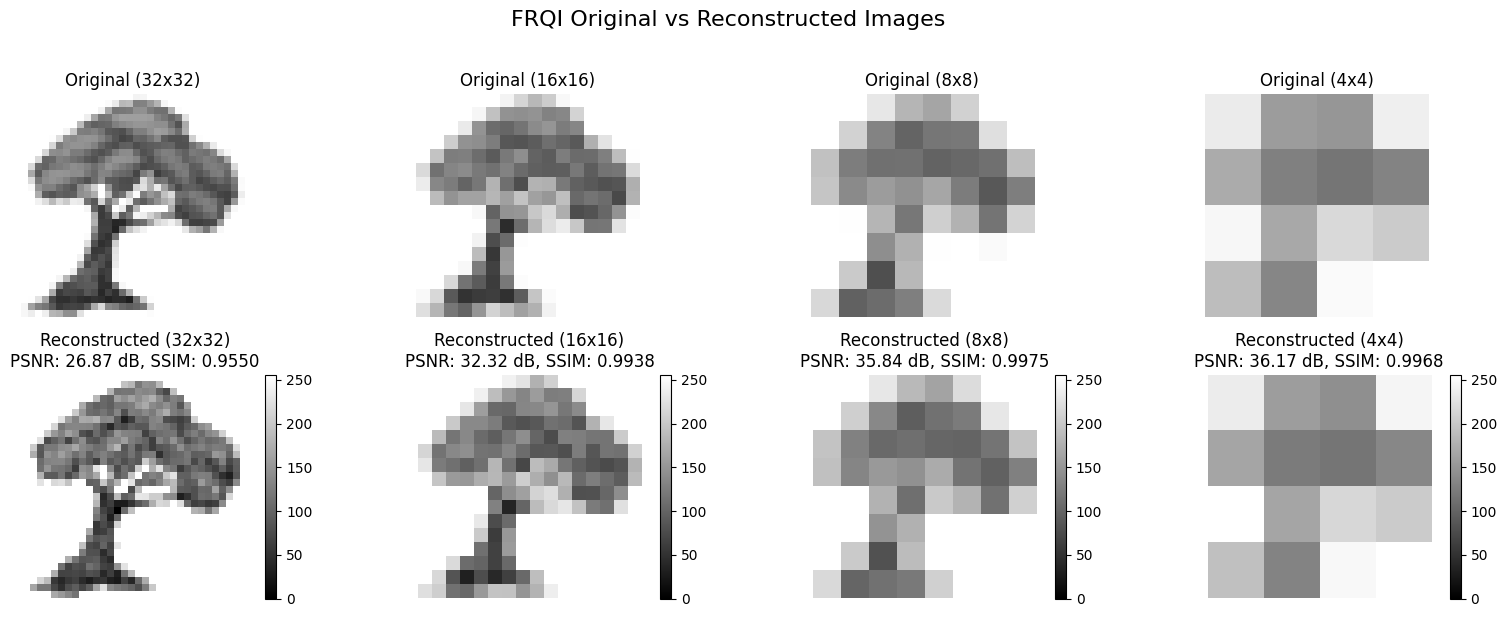

In [ ]:

n = len(sizes)  # number of image sizes
fig, axes = plt.subplots(2, n, figsize=(4*n, 6))
fig.suptitle("FRQI Original vs Reconstructed Images", fontsize=16, y=1.02)
# Row 1: Original images
for i in range(n):
    axes[0, i].imshow(img_array[i], cmap="gray", vmin=0, vmax=255)
    axes[0, i].set_title(f"Original ({sizes[i]}x{sizes[i]})")
    axes[0, i].axis("off")

# Row 2: Reconstructed images
for i in range(n):
    im = axes[1, i].imshow(reconstructed[i], cmap="gray", vmin=0, vmax=255)
    axes[1, i].set_title(f"Reconstructed ({sizes[i]}x{sizes[i]})\nPSNR: {psnr_vals[i]:.2f} dB, SSIM: {ssim_vals[i]:.4f}")
    axes[1, i].axis("off")
    fig.colorbar(im, ax=axes[1, i])

plt.tight_layout()
plt.show()